In [1]:
from IPython.display import Image

## Implementing

Following along with [Chollet's example in his Deep Learning book](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb), he builds a GAN over a bunch of frog images from CIFAR. It's a great, succinct bit of code, so I'm not going to copy-paste it all here. Instead, I'll comment on the things that stand out as non-obvious and important section by section

### Building the Generator

- Everything starts off by defining the `generator_input` relative to some `latent_dim`-- the dimension of our latent space that we're going to use to generate noise. He defines this to be 32, I've seen it as high as 100-200 for larger image applications

- The first hidden layer is a large Dense layer that is comprised of `(smaller height, smaller width, lots of filters)`. This learns to generate pixel-level representations from our latent space. We reshape this into an actual image before doing any convolution.

- Each layer of our Generator (and later with the Discriminator) leverages a `LeakyReLU()`, not `ReLU()` as an activation function. This is because sparsity (many, many zeros for negative values that `ReLU()` provides) is an undesirable trait in a GAN-- less non-zero weights means less levers the Generator can pull to fool the Discriminator.

#### Conv2DTranspose

This one threw me for a loop. 

The basic idea of the `Conv2DTranspose()` layer is for upsampling our small, random images into something the same size as our real data, `X`.

Particularly, [this YouTube video](https://www.youtube.com/watch?v=ByjaPdWXKJ4&feature=youtu.be&t=16m59s) provided a nice visual representation of what the *reverse* of a Convolution operation accomplishes.

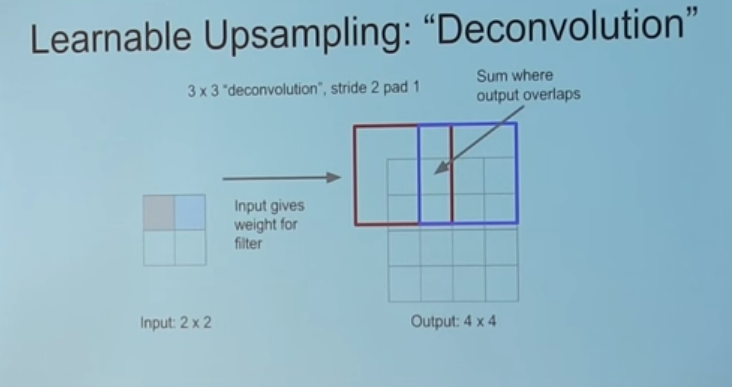

In [2]:
Image('images/conv2dtranspose.PNG')

Moreover, [this repo](https://github.com/vdumoulin/conv_arithmetic#transposed-convolution-animations) has some great graphics to cement the intuition for Transpose Convolution-- particularly when it comes to understanding what "stride" means in this context.

**Note:** Setting `strides=2` means that you insert a blank space between each pixel in the original image. This (with `padding=same`) is how we achieve upsampling from `16` to `32`.

**One more note:** Chollet has a great nugget of wisdom with respect to `kernel_size` vs `strides` for GANs

>In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that is divisible by the stride size, whenever we use a strided Conv2DTranpose or Conv2D in both the generator and discriminator.

### Building the Discriminator

Pretty straight-forward.

As with the Discriminator, we avoid sparsity by utilizing `LeakyReLU()` layers. We also introduce randomness to the learning by tossing a healthy amount of `Dropout()` before the final `Dense()` layer, used to do the `0/1` classification.

### Building the GAN

One tricky thing to note is the order that we compile our `Model()` objects.

The general pseudocode of training is:

- Train the Discriminator by itself
- Pass those gradients back to the Generator
- Train the Generator

So you'll notice that when constructing the Networks that we use to construct the GAN, **he compiles the Discriminator, but not the Generator**.

This is because the `model.compile()` step *freezes the Network definition (particularly all of the `layer.trainable` values)* as-is.

**Only after the Discriminator is frozen** do we turn around and say `discriminator.trainable = False`. Then we build the GAN by piping the noise into the Generator and the Generator into the Discriminator. And after we specify that the overall model takes noise from the latent space and outputs the prediction on an image do we compile the network in its entirety.

This compiled object will have both models connected and talking to one another via gradients, but only the `Generator` parameters will be trainable.

### Training

He does a lot of data prep here, particularly regarding:

- Loading the dataset
- Scaling
- Handling batch size

That's all pretty straight-forward and not specific to GANs

#### Train the Discriminator

Before we can train our discrimator to sort real from fake images, we need some fake images, so we:

- Sample random noise from the latent space
- Use our Generator to make fake images via `generator.predict()`

Where we'll diverge (and most example I've seen do...) is **not** concatenating the real and fake images into one list. This allows us to better-monitor the loss and accuracy for both Networks over both groups.

Then we'll leverage the same "multiply by `0.05 * normal_noise`" trick that he uses. This dampens our Discriminator from learning TOO quickly.

Then we train the Discriminator with `discriminator.train_on_batch()` (which only goes through one training step)

#### Train the Generator

Now, we're going to generate **all** fake images, lie and say they're real, and send them over to the Discriminator.

We use `gan.train_on_batch()`, passing in latent noise and a bunch of True's. Because the Generator is hooked into the Discriminator, all of the gradients from prediction error flow backward and inform the Generator. Recall that **every single image sent over was fake, but we said it was true**, let's consider both examples:

- The Discriminator says "This is real": It matches the label we sent over, reinforcing this kind of image being sent in the future
- The Discriminator says "This is fake": Whatever the Generator thought it'd learned about the underling data distribution `pr_data`, was clearly not representative of how we get our images. Try something else.

In either case, this is a win-win for our Generator... assuming that there's some healthy mix of fooling and not-foolilng the Discriminator.

And therein lies the rub.